Author: Vinícius Antoino Ramos Zecca

LinkedIn: /viniciusarz

Github: /ViniciusARZ

## Problem Analysed

ESports are in a constant growth, and as other sports there are various elements that contribute to a winning outcome. This analysis is a study of Machine Learning Algorithms to create a model based on the data from the first 10 minutes of a high-ranking League of Legends match, [published on Kaggle](https://www.kaggle.com/bobbyscience/league-of-legends-diamond-ranked-games-10-min), with the objective of predicting the final outcome.

## Project Goal
Study Data Science and Machine Learning Algorithms using League of Legends Dataset and previously done analysis and modelling to build valuable knowledge.

# COLLECT PHASE

In [1]:
# Import packages
import pandas as pd
import numpy as np
np.random.seed(42)
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics 

from xgboost import XGBRFClassifier, XGBClassifier

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
# Load data and display dataset's info
df = pd.read_csv('/content/high_diamond_ranked_10min.csv')
display(df.head(5), df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  blueHeralds                   9879 non-null   int64  
 11  blueTowersDestroyed           9879 non-null   int64  
 12  blueTotalGold                 9879 non-null   int64  
 13  blu

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,0,0,17210,6.6,17039,195,36,643,-8,19.5,1721.0,15,6,0,6,9,8,0,0,0,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,0,0,14712,6.6,16265,174,43,-2908,-1173,17.4,1471.2,12,1,1,5,5,2,2,1,1,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,0,0,16113,6.4,16221,186,46,-1172,-1033,18.6,1611.3,15,3,1,11,7,14,0,0,0,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,1,0,15157,7.0,17954,201,55,-1321,-7,20.1,1515.7,15,2,1,5,4,10,0,0,0,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,0,0,16400,7.0,18543,210,57,-1004,230,21.0,1640.0,17,2,1,6,6,7,1,1,0,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


None

# PREPARE PHASE

## Data Preparation

From source's information, the dataset was collected by an API from Riot, League of Legends' company, the bias or poor quality data probability is very low, so no outlier or major clean-up will be done. Some values among attributes might be shown later as outliers, but this can also mean that the feature from the game that it represents may have impact in winning or not.

To make it easier, the total dataset is going to be split into two:
- df_big: Unaltered dataframe with all original features included.
- df_select: Altered dataframe with aggregate columns removed and only controllable features included.

In [4]:
# Since gameId is an identifier and not important for the model, it'll be dropped
df.drop('gameId', axis=1, inplace=True)
df.head()

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,0,28,2,1,9,6,11,0,0,0,0,17210,6.6,17039,195,36,643,-8,19.5,1721.0,15,6,0,6,9,8,0,0,0,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,0,12,1,0,5,5,5,0,0,0,0,14712,6.6,16265,174,43,-2908,-1173,17.4,1471.2,12,1,1,5,5,2,2,1,1,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,0,15,0,0,7,11,4,1,1,0,0,16113,6.4,16221,186,46,-1172,-1033,18.6,1611.3,15,3,1,11,7,14,0,0,0,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,0,43,1,0,4,5,5,1,0,1,0,15157,7.0,17954,201,55,-1321,-7,20.1,1515.7,15,2,1,5,4,10,0,0,0,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,0,75,4,0,6,6,6,0,0,0,0,16400,7.0,18543,210,57,-1004,230,21.0,1640.0,17,2,1,6,6,7,1,1,0,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


In [5]:
# Create copy of full df to keep the total one
df_total = df.copy()

In [6]:
# Create df with only target variable and directly controllable aspects of the game.
df_select = df[['blueWins','blueWardsPlaced', 'blueWardsDestroyed', 
                'blueFirstBlood', 'blueKills', 'blueDeaths', 'blueAssists', 
                'blueDragons', 'blueHeralds', 'blueTowersDestroyed', 
                'blueTotalMinionsKilled', 'blueTotalJungleMinionsKilled',
                'redWardsPlaced', 'redWardsDestroyed', 
                'redFirstBlood', 'redKills', 'redDeaths', 'redAssists', 
                'redDragons', 'redHeralds', 'redTowersDestroyed', 
                'redTotalMinionsKilled', 'redTotalJungleMinionsKilled']]
df_select.head()

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redDragons,redHeralds,redTowersDestroyed,redTotalMinionsKilled,redTotalJungleMinionsKilled
0,0,28,2,1,9,6,11,0,0,0,195,36,15,6,0,6,9,8,0,0,0,197,55
1,0,12,1,0,5,5,5,0,0,0,174,43,12,1,1,5,5,2,1,1,1,240,52
2,0,15,0,0,7,11,4,1,0,0,186,46,15,3,1,11,7,14,0,0,0,203,28
3,0,43,1,0,4,5,5,0,1,0,201,55,15,2,1,5,4,10,0,0,0,235,47
4,0,75,4,0,6,6,6,0,0,0,210,57,17,2,1,6,6,7,1,0,0,225,67


# EXPLORE PHASE

EDA on the correlation between variables

In [7]:
# data distribution and outliers.

def corr_heatmap(df, digits=3, cmap='PuOr'):
    # Correlation matrix
    correl = df.corr().round(digits)
    correl
    # Mask for upper triangle
    mask = np.zeros_like(correl)
    mask[np.triu_indices_from(mask)] = True
    # Heatmap correlation matrix
    fig, ax = plt.subplots(figsize=((len(df.columns)),(len(df.columns))))
    sns.heatmap(correl, annot=True, ax=ax, cmap=cmap, vmin=-1, vmax=1,\
                mask=mask);
    return fig, ax

    
def visual_eda(df, target, col):
    # Copy variables of df and col
    data = df[col].copy()
    name = col
    # Calc mean and median
    median = data.median()
    mean = data.mean()
    # Create gridspec for plots
    fig = plt.figure(figsize=(11, 6))
    gs = GridSpec(nrows=2, ncols=2)

    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[1, 0])
    ax2 = fig.add_subplot(gs[:, 1])

    # Plot distribution 
    sns.histplot(data,alpha=0.5,stat='density',ax=ax0)
    sns.kdeplot(data,color='green',label='KDE',ax=ax0)
    ax0.set(ylabel='Density',title=name)
    ax0.set_title(F"Distribution of {name}")
    ax0.axvline(median,label=f'median={median:,}',color='black')
    ax0.axvline(mean,label=f'mean={mean:,}',color='black',ls=':')
    ax0.legend()

    # Plot Boxplot
    sns.boxplot(data,x=col,ax=ax1)
    ax1.set_title(F"Box Plot of {name}")

    # Plot Scatterplot to illustrate linearity
    sns.regplot(data=df, x=col, y=target, line_kws={"color": "red"}, ax=ax2)
    ax2.set_title(F"Scatter Plot of {name}")

    # Tweak Layout & Display
    fig.tight_layout()
   
    return fig, gs

(<Figure size 2808x2808 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff764b6bcd0>)

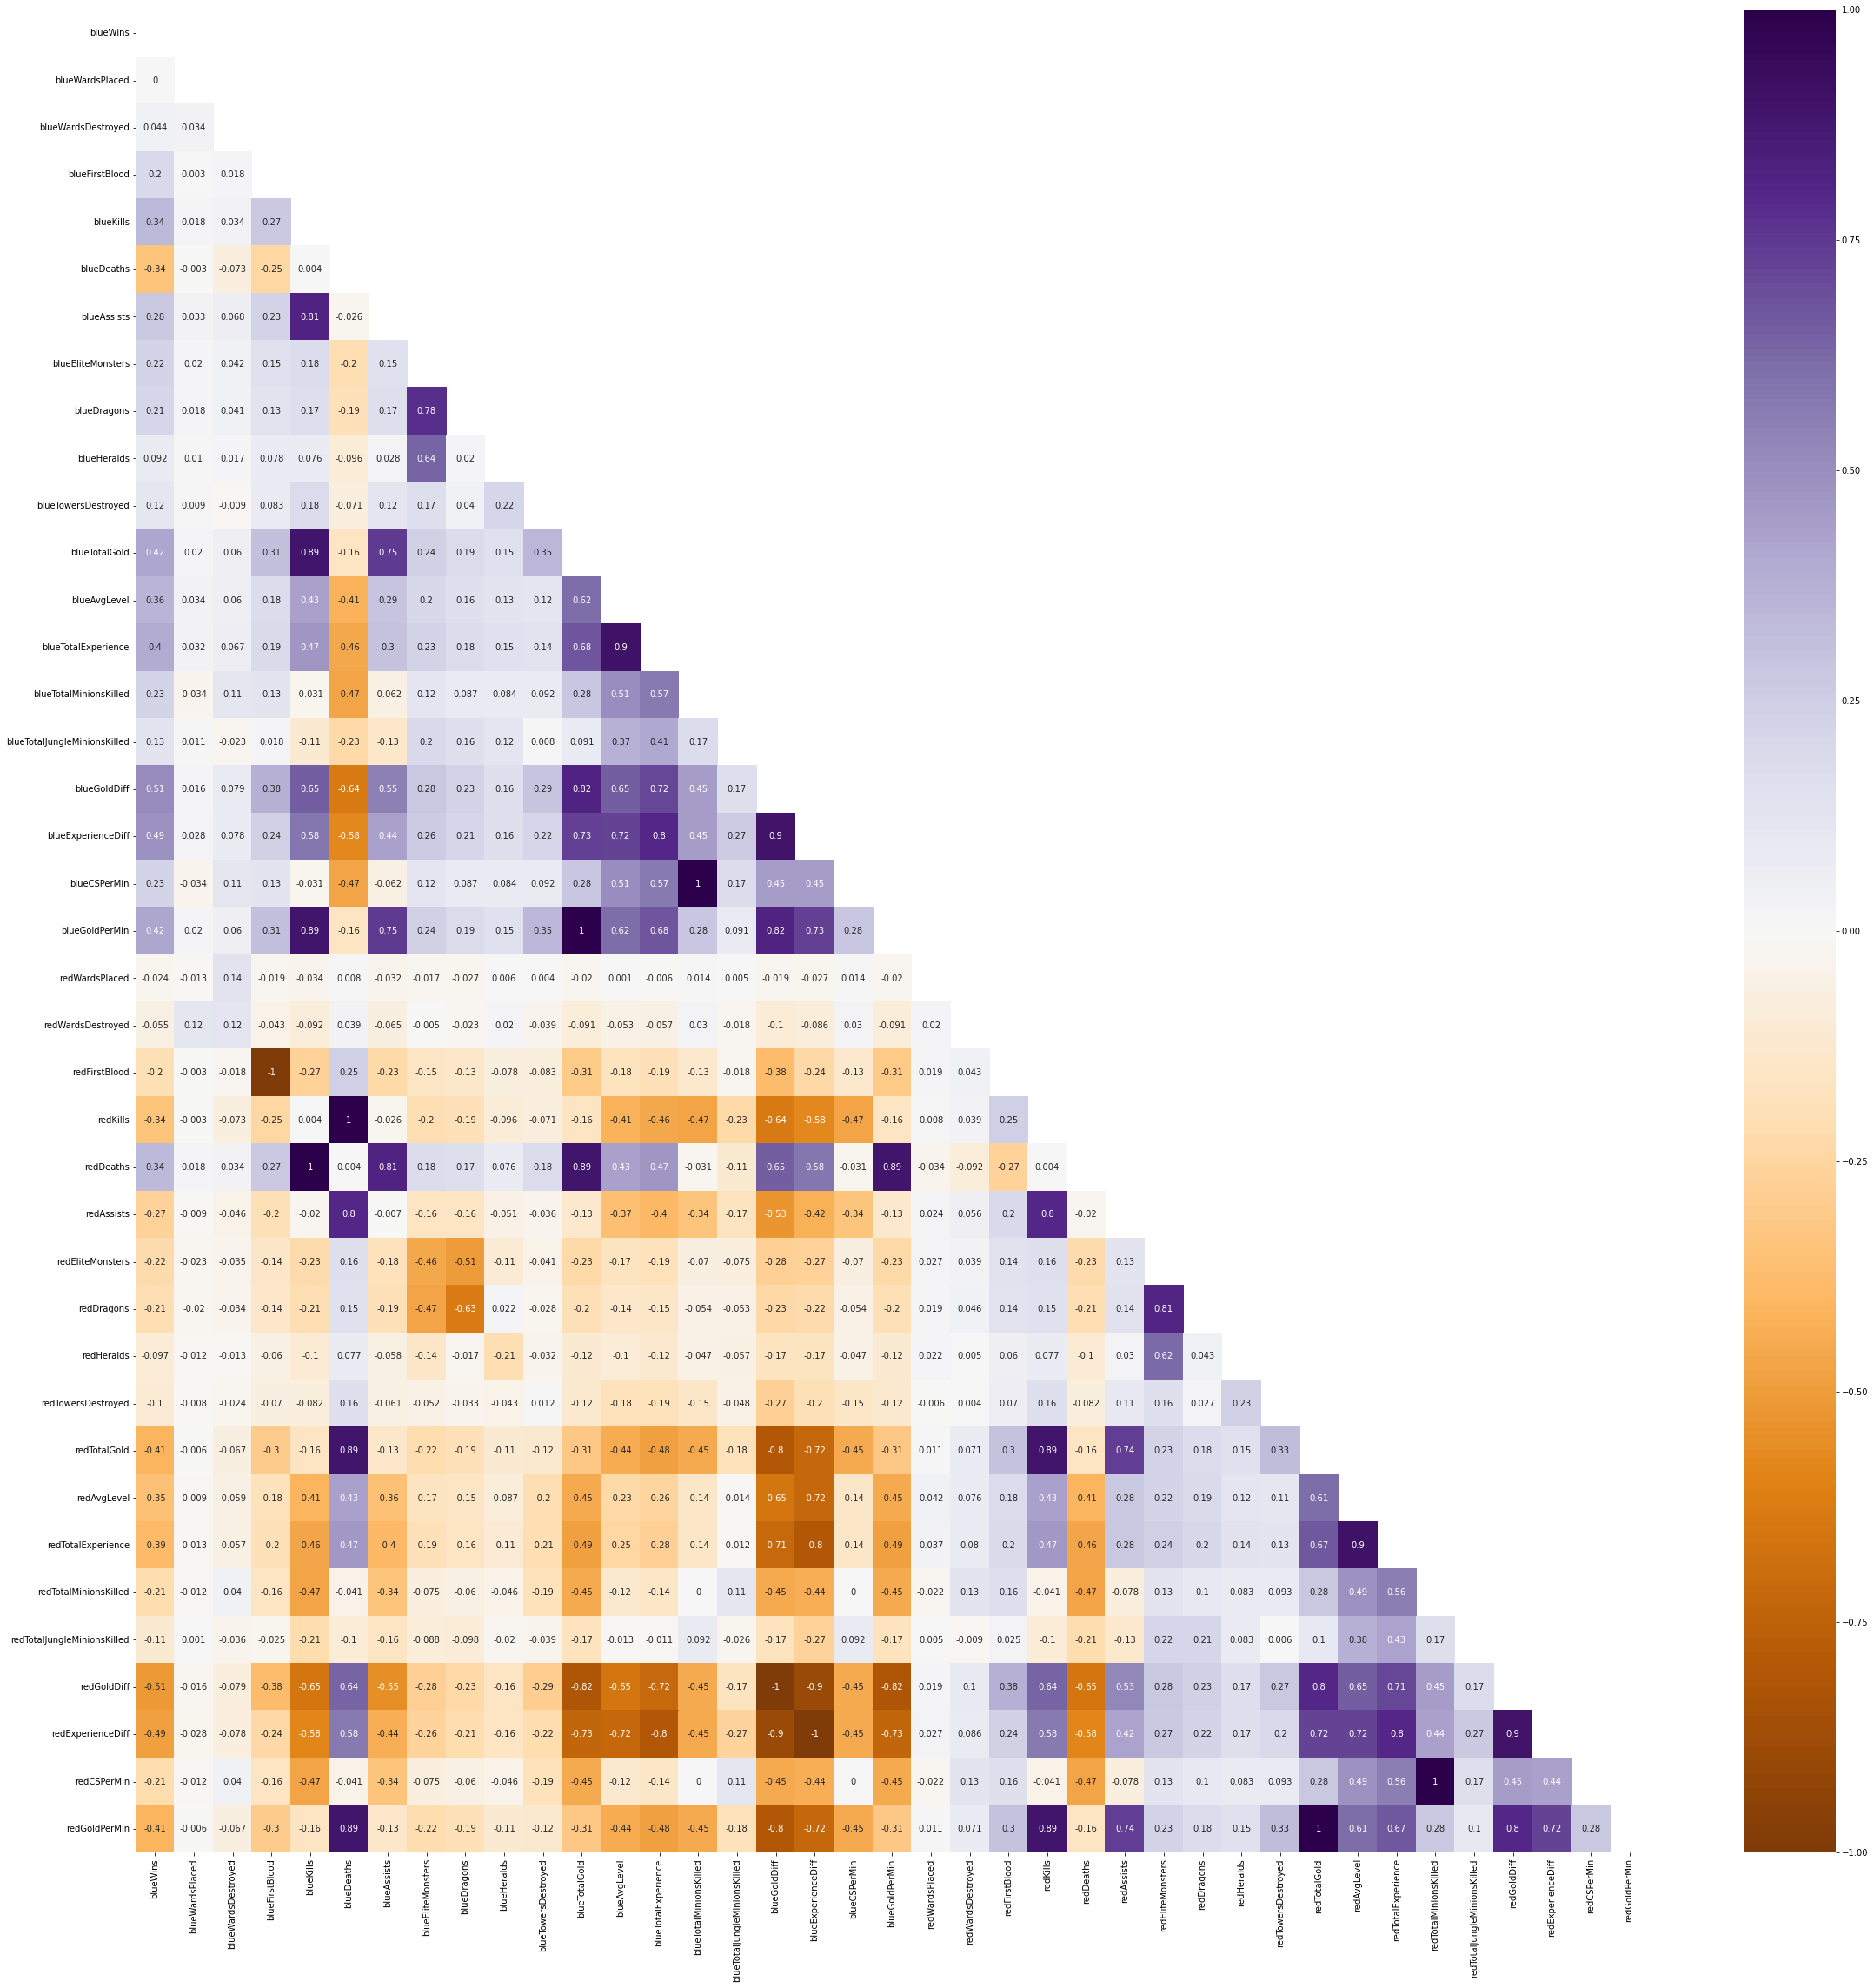

In [8]:
# Create correlation heatmap for the Full Dataset
corr_heatmap(df_total)

Looking at the heatmap, it's clear that multiple attributes that have high multicollinearity. This might be problematic for regression models, because shows a larger variance among a lot of variables, so the full dataset will not be used.

(<Figure size 1656x1656 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff7628f8f90>)

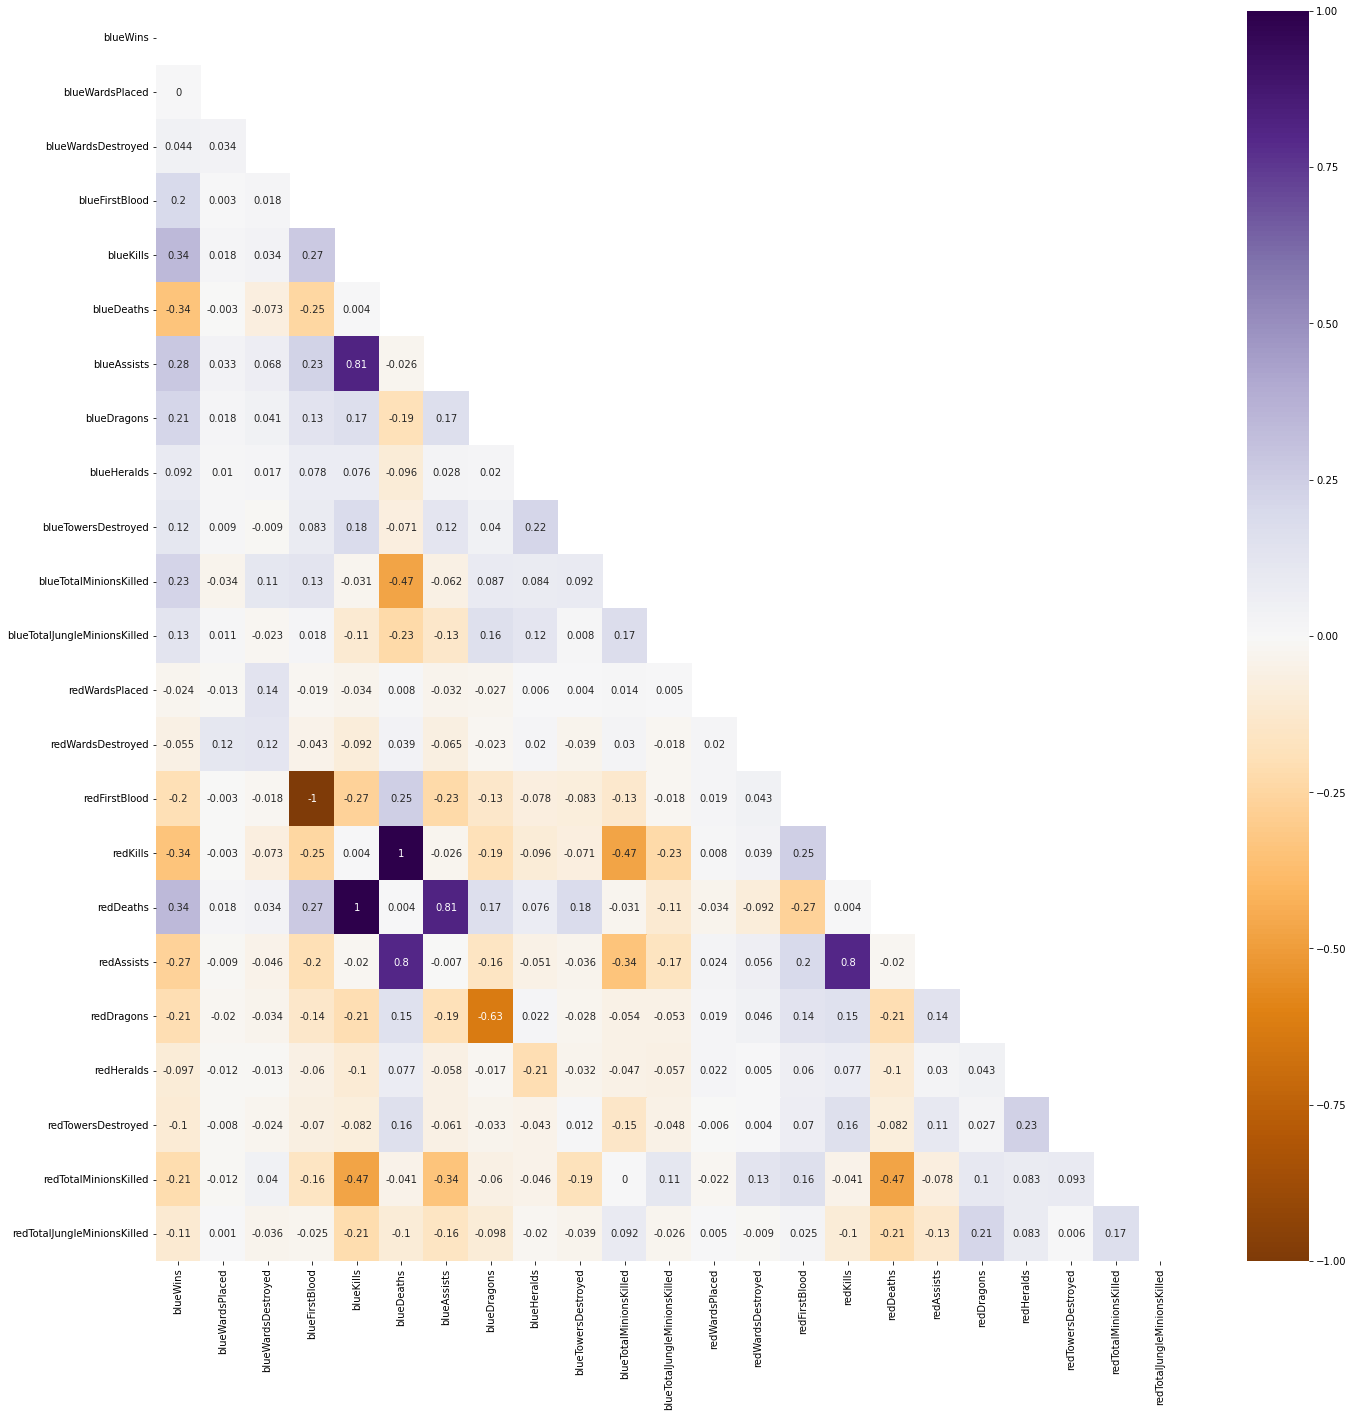

In [9]:
# Create correlation heatmap for the selected dataset
corr_heatmap(df_select)

Multicollinearity isn't a problem here, but there are problems with attributes fully directly related, for example First Blood, Kills and Deaths from the red team are perfect inverses from the blue ones, as expected. Because of that, doesn't make sense to use them in the model.

In [10]:
# Drop highly columns with high multicollinearity.
df_select.drop(columns=['blueKills', 'blueDeaths', 'blueFirstBlood'], 
               inplace=True)
df_select.columns

Index(['blueWins', 'blueWardsPlaced', 'blueWardsDestroyed', 'blueAssists',
       'blueDragons', 'blueHeralds', 'blueTowersDestroyed',
       'blueTotalMinionsKilled', 'blueTotalJungleMinionsKilled',
       'redWardsPlaced', 'redWardsDestroyed', 'redFirstBlood', 'redKills',
       'redDeaths', 'redAssists', 'redDragons', 'redHeralds',
       'redTowersDestroyed', 'redTotalMinionsKilled',
       'redTotalJungleMinionsKilled'],
      dtype='object')

Visualizing the distribution for different attributes in order to have insights and trying to find outliers.

Checking relationship between the blue team wins and the team total experience

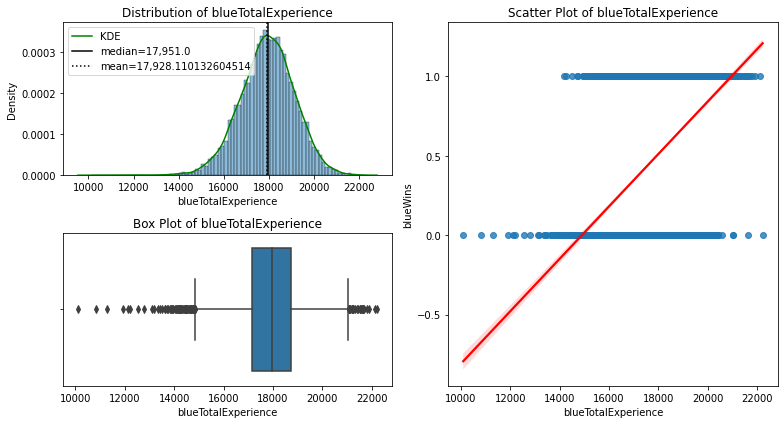

In [11]:
# Plot visualization for blueTotalExperience vs blueWins.
visual_eda(df_total, 'blueWins', 'blueTotalExperience');

Now checking for the inverse experience, the ones for the losing team.

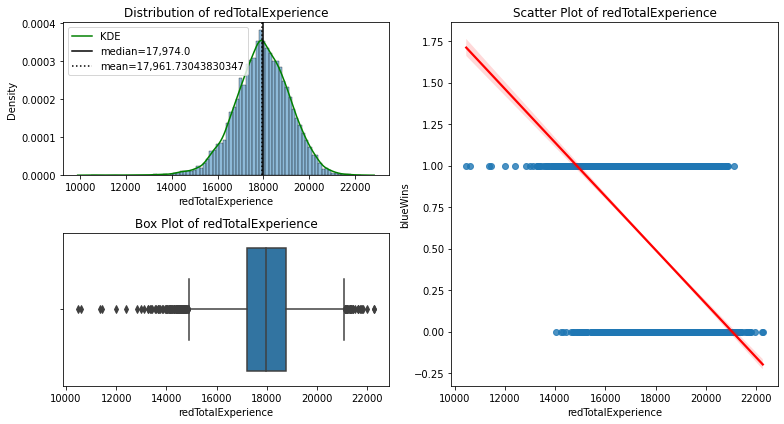

In [12]:
# Plot visualization for redTotalExperience vs blueWins.
visual_eda(df_total, 'blueWins', 'redTotalExperience');

Another property that might be good to check is gold

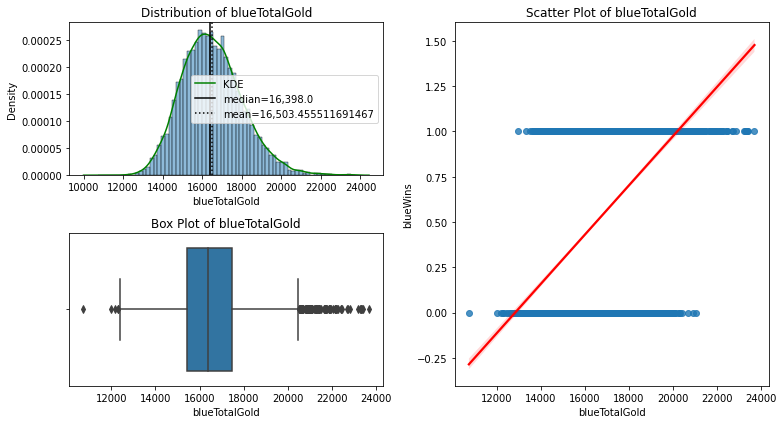

In [13]:
# Plot visualization for blueTotalGold vs blueWins.
visual_eda(df_total, 'blueWins', 'blueTotalGold');

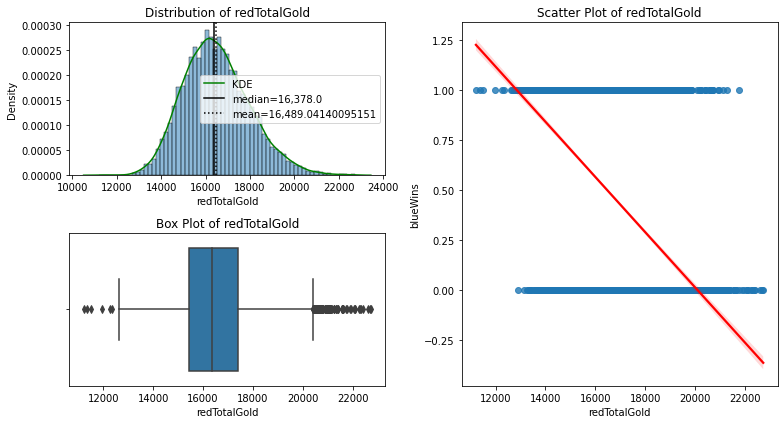

In [14]:
# Plot visualization for redTotalGold vs blueWins.
visual_eda(df_total, 'blueWins', 'redTotalGold');

As expected, we can see a generally negative correlation between red team total gold and experience and blue team win, with a positive correlation on the opposite.

# STOPPED HERE

# PROCESS PHASE - MODEL BUILDING

## Modeling
As seen, there's a relationship between experience, gold and winning a match. To dive more deeply in how they affect the outcome, models will be created to analyse features and try to achieve accuracy to predict the outcome of a match and identify features that have the highest impacts.
Model types used:
1. Logistic Regression
2. Random Forest
3. XGBoost: Random Forest

Logistic Regression in this case is going to be used as a comparison feature on more complex algorithimic models. Random Forest and XGBoost models will be studied to see if an ensemble method might provide a better predictive model, while also keeping in consideration the issue of overfitting.

In [45]:
# Create functions to facilitate scaling, fiting and evaluating multiple 
# dataframes.

def evaluate_model(model, X_train, y_train, X_test, y_test, digits=4, 
                   figsize=(10,5), params=False): 
        
    # Get Predictions
    y_hat_test = model.predict(X_test)
    y_hat_train = model.predict(X_train)
    
    # Classification Report / Scores 

    print("****CLASSIFICATION REPORT - TRAINING DATA****")
    
    print(metrics.classification_report(y_train,y_hat_train, digits=digits))
    

    print("****CLASSIFICATION REPORT - TEST DATA****")
    
    print(metrics.classification_report(y_test,y_hat_test, digits=digits))

    print("****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****")

    
    fig, axes = plt.subplots(ncols=2, 
                             figsize=figsize)
    
    # Confusion Matrix
    metrics.plot_confusion_matrix(model, X_test,
                                  y_test,normalize='true',
                                 cmap='Purples',ax=axes[0])
    axes[0].set_title('Confusion Matrix')
    
    # Plot ROC Curve
    metrics.plot_roc_curve(model,X_test,y_test,ax=axes[1])

    ax = axes[1]
    ax.legend()
    ax.plot([0,1],[0,1], ls='-')
    ax.grid()
    ax.set_title('ROC AUC Curve')
    
    plt.tight_layout()
    plt.show()
    
    if params == True:
        print("****MODEL PARAMETERS****")
        params = pd.DataFrame(pd.Series(model.get_params()))
        params.columns=['parameters']
        display(params)
        
    
def split_scale(df, target, scaler=StandardScaler()):
    # Separate X and y
    target = target
    y = df[target]
    X = df.drop(target, axis=1)

    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    # Get list of column names
    cols = X_train.columns
    
    # Scale columns
    scaler = scaler
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=cols)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=cols)
    
    return X_train, X_test, y_train, y_test


def fit_eval(model, X_train, y_train, X_test, y_test, digits=4, 
             figsize=(10,5), params=False):
    model.fit(X_train, y_train)

    evaluate_model(model, X_train, y_train, X_test, y_test, digits=digits, 
                   figsize=figsize, params=params)
    
    return model

In [18]:
# Create training and test data splits.
X_train_select, X_test_select, y_train_select, \
                y_test_select = split_scale(df_select, 'blueWins')
X_train_big, X_test_big, y_train_big, \
             y_test_big = split_scale(df_total, 'blueWins')

## Basic Logistic Regression on df_select

On the Logistic Regression model, the selected dataset `df_select` because of the already addressed issue of multicollinearity specifically for this model.

****CLASSIFICATION REPORT - TRAINING DATA****
              precision    recall  f1-score   support

           0     0.7207    0.7256    0.7231      3713
           1     0.7224    0.7175    0.7200      3696

    accuracy                         0.7216      7409
   macro avg     0.7216    0.7215    0.7215      7409
weighted avg     0.7216    0.7216    0.7215      7409

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0     0.7268    0.7298    0.7283      1236
           1     0.7282    0.7253    0.7268      1234

    accuracy                         0.7275      2470
   macro avg     0.7275    0.7275    0.7275      2470
weighted avg     0.7275    0.7275    0.7275      2470

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


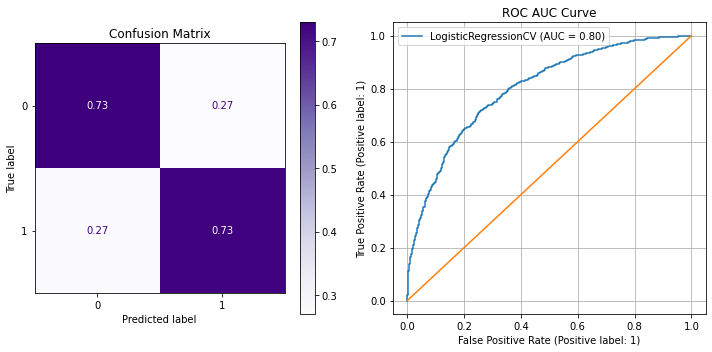

In [19]:
# Fit and evaluate df_select on a Logistic Regression model.
log_select = fit_eval(LogisticRegressionCV(random_state=42), \
                      X_train_select, y_train_select, \
                      X_test_select, y_test_select)

Looking at the recall score, which means the percentage of positive cases that the model caught, it is 0.7215 on the training data, as our test data received a macro recall score of 0.7275, meaning that of the true wins and losses, the Logistic Regression model is predicting 72.75% of them correctly.

## Random Forest

### df_select

****CLASSIFICATION REPORT - TRAINING DATA****
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      3713
           1     1.0000    1.0000    1.0000      3696

    accuracy                         1.0000      7409
   macro avg     1.0000    1.0000    1.0000      7409
weighted avg     1.0000    1.0000    1.0000      7409

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0     0.7169    0.7233    0.7201      1236
           1     0.7204    0.7139    0.7171      1234

    accuracy                         0.7186      2470
   macro avg     0.7186    0.7186    0.7186      2470
weighted avg     0.7186    0.7186    0.7186      2470

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


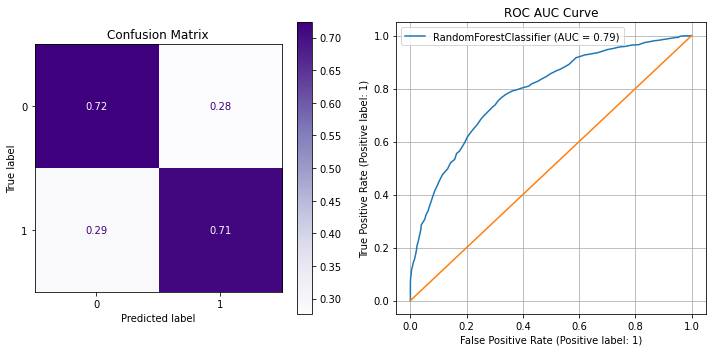

RandomForestClassifier(random_state=42)

In [21]:
# Fit and evaluate Random Forest on df_select.
fit_eval(RandomForestClassifier(random_state=42), X_train_select, \
         y_train_select, X_test_select, y_test_select)

### df_big

****CLASSIFICATION REPORT - TRAINING DATA****
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      3713
           1     1.0000    1.0000    1.0000      3696

    accuracy                         1.0000      7409
   macro avg     1.0000    1.0000    1.0000      7409
weighted avg     1.0000    1.0000    1.0000      7409

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0     0.7173    0.7371    0.7271      1236
           1     0.7292    0.7091    0.7190      1234

    accuracy                         0.7231      2470
   macro avg     0.7232    0.7231    0.7230      2470
weighted avg     0.7232    0.7231    0.7230      2470

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


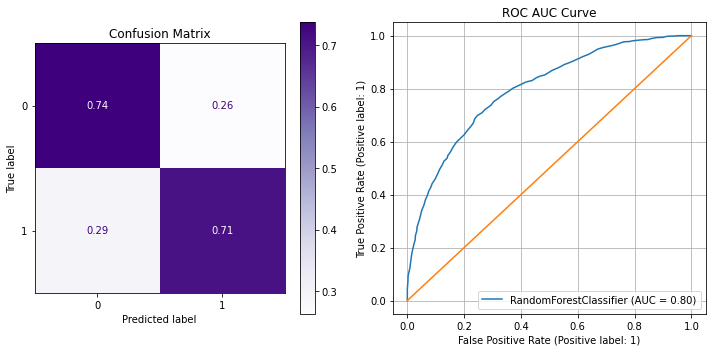

RandomForestClassifier(random_state=42)

In [22]:
# Fit and evaluate Random Forest on df_big. 
fit_eval(RandomForestClassifier(random_state=42), X_train_big, y_train_big, \
                                                  X_test_big, y_test_big)

The scores are pretty much the same as on the Logistic Regression model, but using Random Forest an overfitting issue can be seen, which didn't happen on Logistic. This is shown by the 100% accuracy on the training data, so in order to prevent problems it's better to test using XGBoost to find optimal parameters.

## XGBoost: Random Forest

### df_select

****CLASSIFICATION REPORT - TRAINING DATA****
              precision    recall  f1-score   support

           0     0.7019    0.7172    0.7095      3713
           1     0.7095    0.6940    0.7017      3696

    accuracy                         0.7056      7409
   macro avg     0.7057    0.7056    0.7056      7409
weighted avg     0.7057    0.7056    0.7056      7409

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0     0.6912    0.7079    0.6994      1236
           1     0.7002    0.6831    0.6916      1234

    accuracy                         0.6955      2470
   macro avg     0.6957    0.6955    0.6955      2470
weighted avg     0.6957    0.6955    0.6955      2470

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


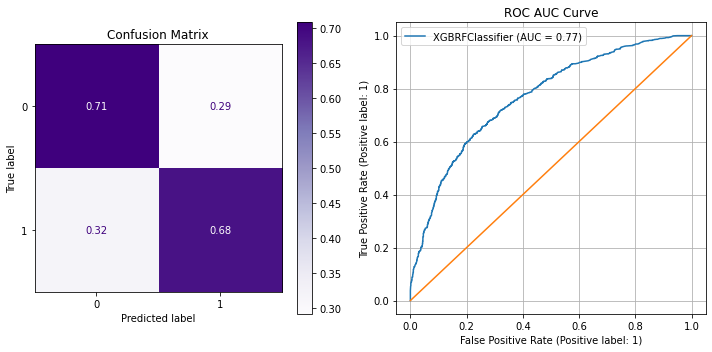

In [23]:
# Fit and evaluate XGBoost on df_select.
xgb_select = fit_eval(XGBRFClassifier(random_state=42), \
                      X_train_select, y_train_select, \
                      X_test_select, y_test_select)

### df_big

****CLASSIFICATION REPORT - TRAINING DATA****
              precision    recall  f1-score   support

           0     0.7161    0.7590    0.7369      3713
           1     0.7424    0.6978    0.7194      3696

    accuracy                         0.7284      7409
   macro avg     0.7293    0.7284    0.7282      7409
weighted avg     0.7292    0.7284    0.7282      7409

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0     0.6993    0.7565    0.7268      1236
           1     0.7343    0.6742    0.7030      1234

    accuracy                         0.7154      2470
   macro avg     0.7168    0.7154    0.7149      2470
weighted avg     0.7168    0.7154    0.7149      2470

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


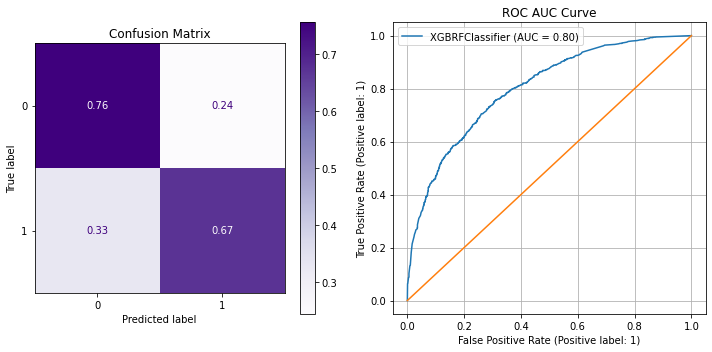

XGBRFClassifier(random_state=42)

In [24]:
# Fit and evaluate XGBoost on df_big.
fit_eval(XGBRFClassifier(random_state=42), \
         X_train_big, y_train_big, X_test_big, y_test_big)

Using XGBRFClassifier apparently solved the issue of overfitting, and the recall score is close to the Random Forest Model and a bit different, specially in predicted label, but on the df_select version had a AUC of 0.3 less than Logistic Regression.

# Analyse

## Best Performing Models
As we saw from our results above, we can conclude that our basic Logistic Regression model log_select and XGBoost gridsearch xgb_grid.best_estimator_ returned the highest recall scores of 0.7275 and 0.7170 respectively.

### Logistic Regression

****CLASSIFICATION REPORT - TRAINING DATA****
              precision    recall  f1-score   support

           0     0.7207    0.7256    0.7231      3713
           1     0.7224    0.7175    0.7200      3696

    accuracy                         0.7216      7409
   macro avg     0.7216    0.7215    0.7215      7409
weighted avg     0.7216    0.7216    0.7215      7409

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0     0.7268    0.7298    0.7283      1236
           1     0.7282    0.7253    0.7268      1234

    accuracy                         0.7275      2470
   macro avg     0.7275    0.7275    0.7275      2470
weighted avg     0.7275    0.7275    0.7275      2470

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


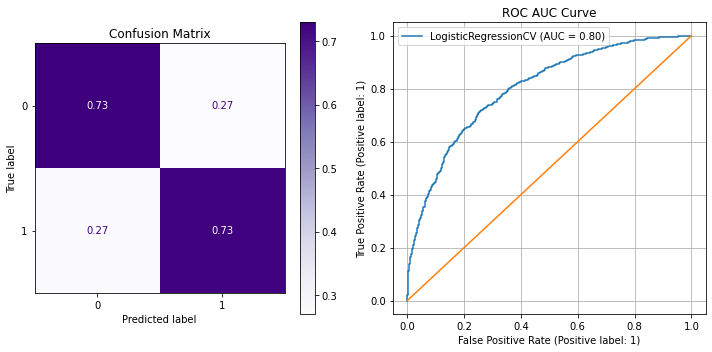

****MODEL PARAMETERS****


,parameters
Cs,10
class_weight,None
cv,None
dual,False
fit_intercept,True
intercept_scaling,1.0
l1_ratios,None
max_iter,100
multi_class,auto
n_jobs,None


In [31]:
# Evaluate best estimating Logistic Regression model.
evaluate_model(log_select, X_train_select, y_train_select, \
               X_test_select, y_test_select, params=True)

### XGBoost: Random Forest

****CLASSIFICATION REPORT - TRAINING DATA****
              precision    recall  f1-score   support

           0     0.7019    0.7172    0.7095      3713
           1     0.7095    0.6940    0.7017      3696

    accuracy                         0.7056      7409
   macro avg     0.7057    0.7056    0.7056      7409
weighted avg     0.7057    0.7056    0.7056      7409

****CLASSIFICATION REPORT - TEST DATA****
              precision    recall  f1-score   support

           0     0.6912    0.7079    0.6994      1236
           1     0.7002    0.6831    0.6916      1234

    accuracy                         0.6955      2470
   macro avg     0.6957    0.6955    0.6955      2470
weighted avg     0.6957    0.6955    0.6955      2470

****CONFUSION MATRIX AND ROC-AUC VISUALIZATION****


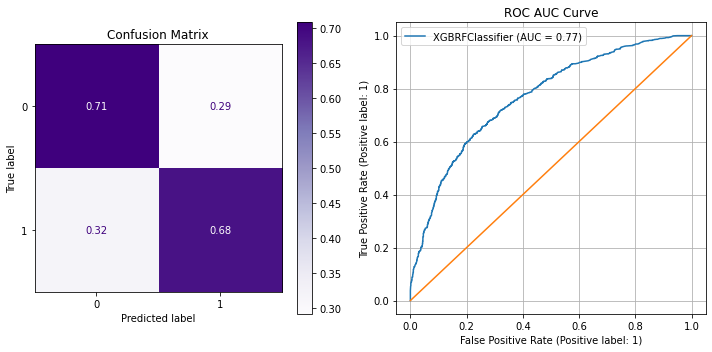

In [27]:
# Fit and evaluate XGBoost on df_select.
xgb_select = fit_eval(XGBRFClassifier(random_state=42), \
                      X_train_select, y_train_select, \
                      X_test_select, y_test_select)

## Logistic Regression Coefficient Analysis

The Logistic Regression found a macro recall score of 0.7275, while the XGBoost Model had a score of 0.6955. This means that the first is capable of correctly identifying 72.75% of wins or losses based on the data collected within the first 10 minutes of each match, while the latest, XGBoost model is able to correctly identify 69.55%.

Now the goal is to extract the feature coefficients and importances in each model in order to identify how much impact each of the elements of the game are likely to have on the outcome of each match. Even though Logistic had a better accuracy, it's important to check in both models to compare how each mathematical function impacts on the weight of the attributes on the prediction algorithm.

Based on these findings, there will be material to provide as to what to focus on when training for competitions, analysing player performance etc.

In [30]:
# Extract coefficients from log_grid.best_estimator_ model.
log_coeff = pd.Series(log_select.coef_.flatten(),
               index=X_train_select.columns).sort_values(ascending=False)
log_coeff

redDeaths                       0.728298
blueTotalJungleMinionsKilled    0.247880
blueTotalMinionsKilled          0.232926
blueTowersDestroyed             0.119629
blueDragons                     0.099816
blueHeralds                     0.053624
blueAssists                     0.035660
blueWardsDestroyed              0.026762
blueWardsPlaced                -0.006887
redWardsDestroyed              -0.027312
redAssists                     -0.041991
redHeralds                     -0.042458
redTowersDestroyed             -0.044702
redFirstBlood                  -0.046913
redWardsPlaced                 -0.069512
redDragons                     -0.102748
redTotalJungleMinionsKilled    -0.146236
redTotalMinionsKilled          -0.218261
redKills                       -0.693537
dtype: float64

In [33]:
# Convert log coefficients to odds and subtract 1 to display change in odds.
log_odds = np.exp(log_coeff) - 1
log_odds

redDeaths                       1.071553
blueTotalJungleMinionsKilled    0.281306
blueTotalMinionsKilled          0.262288
blueTowersDestroyed             0.127079
blueDragons                     0.104967
blueHeralds                     0.055087
blueAssists                     0.036303
blueWardsDestroyed              0.027124
blueWardsPlaced                -0.006864
redWardsDestroyed              -0.026942
redAssists                     -0.041122
redHeralds                     -0.041569
redTowersDestroyed             -0.043718
redFirstBlood                  -0.045829
redWardsPlaced                 -0.067151
redDragons                     -0.097646
redTotalJungleMinionsKilled    -0.136046
redTotalMinionsKilled          -0.196084
redKills                       -0.500195
dtype: float64

In [34]:
# Change name of columns
renamed_cols = {'blueKills': 'Kills',
                'blueTotalJungleMinionsKilled': 'Total Jungle Minions Killed',
                'blueTotalMinionsKilled': 'Total Minions Killed',
                'blueTowersDestroyed': 'Towers Destroyed',
                'blueDragons': 'Dragons Killed',
                'blueHeralds': 'Heralds Killed',
                'blueFirstBlood': 'First Blood',
                'blueAssists': 'Assists',
                'blueWardsDestroyed': 'Wards Destroyed',
                'blueWardsPlaced': 'Wards Placed',
                'redWardsDestroyed': 'Enemy Wards Destroyed',
                'redHeralds': 'Enemy Heralds Killed',
                'redTowersDestroyed': 'Enemy Towers Destroyed',
                'redAssists': 'Enemy Assists',
                'redWardsPlaced': 'Enemy Wards Placed',
                'redDragons': 'Enemy Dragons Killed',
                'redTotalJungleMinionsKilled': 'Enemy Total Jungle Minions Killed',
                'redTotalMinionsKilled': 'Enemy Total Minions Killed',
                'blueDeaths': 'Enemy Kills'
               }

log_odds.rename(renamed_cols, inplace=True)
log_odds

redDeaths                            1.071553
Total Jungle Minions Killed          0.281306
Total Minions Killed                 0.262288
Towers Destroyed                     0.127079
Dragons Killed                       0.104967
Heralds Killed                       0.055087
Assists                              0.036303
Wards Destroyed                      0.027124
Wards Placed                        -0.006864
Enemy Wards Destroyed               -0.026942
Enemy Assists                       -0.041122
Enemy Heralds Killed                -0.041569
Enemy Towers Destroyed              -0.043718
redFirstBlood                       -0.045829
Enemy Wards Placed                  -0.067151
Enemy Dragons Killed                -0.097646
Enemy Total Jungle Minions Killed   -0.136046
Enemy Total Minions Killed          -0.196084
redKills                            -0.500195
dtype: float64

In [35]:
# Set theme and style for plots.
sns.set_theme('talk')
sns.set_style('darkgrid')

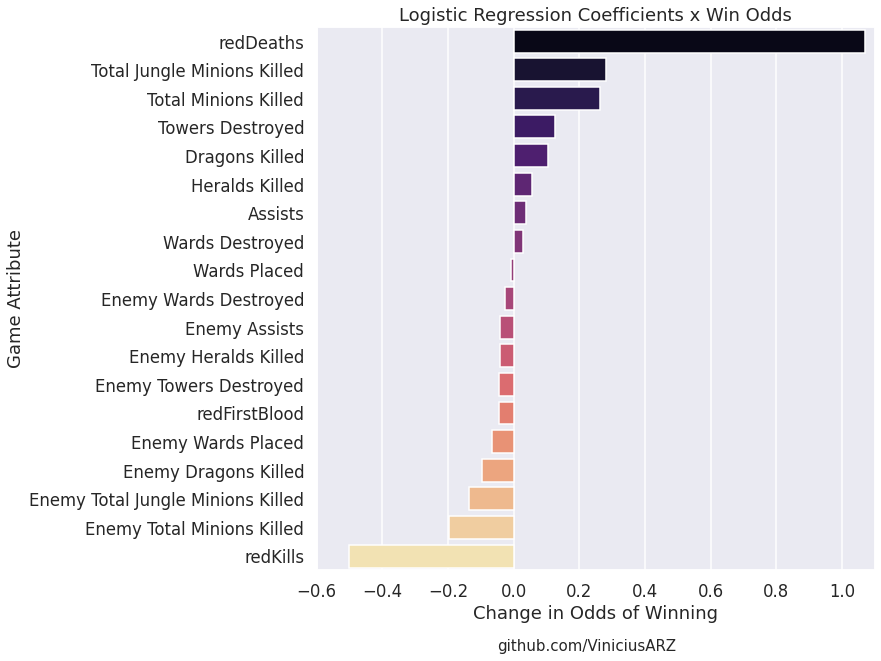

In [58]:
# Create bar plot of feature coefficients as odds.
fig, ax = plt.subplots(figsize=(10,10))

sns.barplot(x=log_odds.values, y=log_odds.index, palette='magma', ax=ax, orient='h')
plt.suptitle("github.com/ViniciusARZ", y=0.03, fontsize=15)
ax.set_title('Logistic Regression Coefficients x Win Odds')
ax.set_xlabel('Change in Odds of Winning')
ax.set_ylabel('Game Attribute')
ax.set_xlim([-.6, 1.1]);


According to the plot based on the Logistic Regression model, what can be seen is that *champion kills and deaths within the first 10 minutes of the match have by far the most impact on the outcome of a match*. Also, *total lane minions and total jungle creeps and dragons are also of high importance*. Unexpectedly, for someone that plays the game for years and watches tournaments, Heralds, vision wards, and towers are of the least importance.

Because our displayed units are in odds, we can see that 1 standard deviation increase in each of the above features will result in the corresponding percent increase or decrease in the odds of winning.

## XGBoost Random Forest Feature Importance

Now we will take a look at the feature importance rankings from our XGBoost model to compare to the size of coefficients found in our Logistic Regression Model.

In [29]:
# Extract coefficients from log_grid.best_estimator_ model.
xgb_importance = pd.Series(xgb_select.feature_importances_,
               index=X_train_select.columns).sort_values(ascending=False)
xgb_importance

redKills                        0.199780
redAssists                      0.168231
redDeaths                       0.160369
blueAssists                     0.114651
blueTotalMinionsKilled          0.101299
redTotalMinionsKilled           0.089671
redDragons                      0.064169
blueDragons                     0.039522
redFirstBlood                   0.032435
blueTotalJungleMinionsKilled    0.029873
blueWardsPlaced                 0.000000
redTowersDestroyed              0.000000
redHeralds                      0.000000
redWardsDestroyed               0.000000
blueWardsDestroyed              0.000000
redWardsPlaced                  0.000000
blueTowersDestroyed             0.000000
blueHeralds                     0.000000
redTotalJungleMinionsKilled     0.000000
dtype: float32

In [43]:
# Change name of columns
xgb_importance.rename(renamed_cols, inplace=True)
xgb_importance

redKills                             0.199780
Enemy Assists                        0.168231
redDeaths                            0.160369
Assists                              0.114651
Total Minions Killed                 0.101299
Enemy Total Minions Killed           0.089671
Enemy Dragons Killed                 0.064169
Dragons Killed                       0.039522
redFirstBlood                        0.032435
Total Jungle Minions Killed          0.029873
Wards Placed                         0.000000
Enemy Towers Destroyed               0.000000
Enemy Heralds Killed                 0.000000
Enemy Wards Destroyed                0.000000
Wards Destroyed                      0.000000
Enemy Wards Placed                   0.000000
Towers Destroyed                     0.000000
Heralds Killed                       0.000000
Enemy Total Jungle Minions Killed    0.000000
dtype: float32

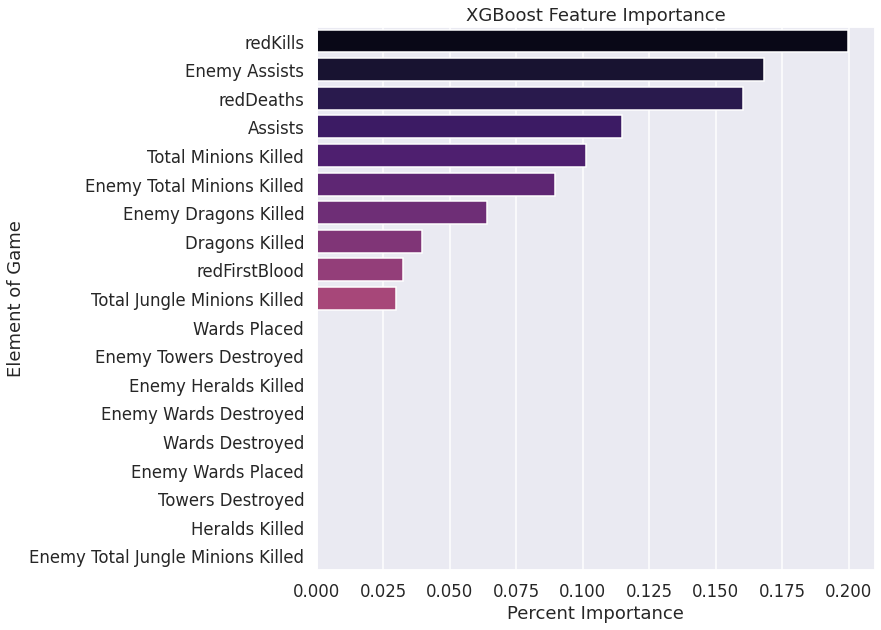

In [47]:
# Create bar plot of feature importances.
fig, ax = plt.subplots(figsize=(10,10))

sns.barplot(x=xgb_importance.values, y=xgb_importance.index, palette='magma', ax=ax, orient='h')

ax.set_title('XGBoost Feature Importance')
ax.set_xlabel('Percent Importance')
ax.set_ylabel('Element of Game');

# SHARE & ACT PHASE

Based on the findings, what can be seen is that that champion kills and assists, lane minions, jungle minions, and dragons have the highest impact on the outcome of a high ranking League of Legends match.

A recommendation would be to focus heavily on the Jungler role. While optimizing an efficient jungle clearing path to maximize the number of jungle creeps killed, the chance of achieving early champion kills might be higher, which will affect, as seen, the probability of winning. Also, maximizing minion kills would have an effect on Gold, which as seen on exploratory phase it's a high dependency towards winning chances, and that combined with the jungler role, the result would be that:

1. Jungler should focus on early game killing strategies, based on this dataset, because early kills has the highest impact
2. Laners should focus on farming, and if the 1. is correctly done a Snowball effect should be created, then more minion farms will be counted and less the other team will have. Which combines 4 of the highest impactful attributes on the probability of winning the game.

Aknowledgement 
I would like to aknowledge the following works where I get inspiration & speed up my project :

[JEREMY ARANCIO](https://www.kaggle.com/jeremyarancio/which-decisions-before-10min-lead-to-win)
[DR.PENGUIN](https://www.kaggle.com/xiyuewang/lol-how-to-win)
[MEHDI GASMI](https://www.kaggle.com/servietsky/league-of-legends-what-to-do-in-first-10-min)
